In [15]:
%matplotlib inline
import pandas as pd
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import heatmap as hm
import feature as ft
import seaborn as sns
import math
from data_reshape import *

In [4]:
a = hm.IVIS()
a.gt_df.head()

,eventid,year,country,region,latitude,longitude,attacktype,kills,wounds,casualties
0,197000000001,1970,Dominican Republic,Central America & Caribbean,18.456792,-69.951164,Assassination,1,0,1
1,197000000002,1970,Mexico,North America,19.432608,-99.133207,Hostage Taking (Kidnapping),0,0,0
2,197001000001,1970,Philippines,Southeast Asia,15.478598,120.599741,Assassination,1,0,1
3,197001000002,1970,Greece,Western Europe,37.983773,23.728157,Bombing/Explosion,0,0,0
4,197001000003,1970,Japan,East Asia,33.580412,130.396361,Facility/Infrastructure Attack,0,0,0


In [114]:
dot_plot_features = ['country', 'year', 'attacktype', 'casualties']
gtd_dot = a.gt_df[dot_plot_features]
gtd_dot.head()

,country,year,attacktype,casualties
0,Dominican Republic,1970,Assassination,1
1,Mexico,1970,Hostage Taking (Kidnapping),0
2,Philippines,1970,Assassination,1
3,Greece,1970,Bombing/Explosion,0
4,Japan,1970,Facility/Infrastructure Attack,0


In [138]:
class Dot_Plot_Data():
    def __init__(self, data, yaxis_vals, xaxis_vals, user_filter1, user_filter2, metric):
        '''Defines attributes of the dot plot'''
        self.data = data[[yaxis_vals, xaxis_vals, user_filter1, user_filter2]]
        self.yaxis_vals = yaxis_vals
        self.xaxis_vals = xaxis_vals
        self.user_filter1 = user_filter1
        self.user_filter2 = user_filter2
        self.subgroups = group_by_columns(self.data, [self.yaxis_vals, self.user_filter1, self.user_filter2], self.xaxis_vals)
        self.metric = metric
        if self.metric == 'occurrences':
            self.count_by_subgroup()
        if self.metric == 'casualties':
            self.sum_by_subgroup()
        
    def count_by_subgroup(self):
        '''Uses group from init function to create a count'''
        self.data = unstack_table(count_by_groups(self.subgroups))
        
    def sum_by_subgroup(self):
        '''Uses sum from init function to create a sum'''
        self.data = unstack_table(sum_by_groups(self.subgroups))
  
    def user_selection(self, year_tuple, attack_type):
        '''Selects year and attack type'''
        years = tuple(range(year_tuple[0], year_tuple[1]))
        self.data = self.data.loc[:, (slice(None), attack_type, years)]
    
    def agg(self):
        '''sum horizontally'''
        self.data = self.data.sum(axis=1)

In [139]:
dot_plot = Dot_Plot_Data(a.gt_df, 'country', 'casualties', 'year', 'attacktype', 'occurrences')

C:\Users\Caroline\Anaconda3\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [140]:
dot_plot.data.head()

count                                               ...    \
attacktype  Armed Assault                                               ...     
year                 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979  ...     
country                                                                 ...     
Afghanistan           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  ...     
Albania               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...     
Algeria               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...     
Andorra               NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  ...     
Angola                NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  1.0  ...     

                                                                            
attacktype  Unknown                                                         
year           2006 2007  2008  2009  2010  2011  2012  2013   2014   2015  
country                                                                     
Afghanistan     9.0  7.0  18.0  11.0  26.0  15.0  74.0  74.0  163.0  186.0  
Albania         NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN  
Algeria         2.0  2.0   4.0   2.0   2.0   1.0   2.0   NaN    1.0    3.0  
Andorra         NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN  
Angola          NaN  NaN   NaN   NaN   1.0   NaN   NaN   NaN    NaN    NaN  

[5 rows x 405 columns]

In [165]:
def remove_zeros(series):
    return series[series > 0]

In [168]:
def convert_series(series, label):
    '''Takes a series and label for the series' values, returns df with 2 columns: the series' row index, & the series' values'''
    converted = pd.DataFrame(series)
    converted.columns = [label]
    converted.reset_index(level=0, inplace=True)
    return converted

In [35]:
def year_interval():
    yr_interval = widgets.IntRangeSlider(value=[1970, 2015],
                                 min=1970,
                                 max=2015,
                                 step=1,
                                 description='Year:',
                                 disabled=False,
                                 continuous_update=False,
                                 orientation='horizontal',
                                 readout=True,
                                 readout_format='i',
                                 slider_color='white',
                                 color='black')
    yr_interval.layout.width = '80%'
    return yr_interval

In [41]:
def attack_type():
    attacktypes = list(set(a.gt_df['attacktype']))
    attack_type = widgets.Dropdown(
                                options=attacktypes,
                                value='Armed Assault',
                                description='Number:',
                                disabled=False,
                                button_style='info') # 'success', 'info', 'warning', 'danger' or ''
    return attack_type

In [102]:
def metric_selection():
    '''
    Return a string of feature name from users' manual pick
    '''
    metric = widgets.ToggleButtons(options={'Occurrences': 'occurrences', 'Casualties': 'casualties'},
                         value='occurrences',
                         description='Indication',
                         disabled=False,
                         button_style='',  # 'success', 'info', 'warning', 'danger' or ''
                         tooltip='Description')
    return metric

In [147]:
def create_dot_plot(attacktype, year_range, metric):
    
    pd.options.mode.chained_assignment = None
    
    dot_plot = Dot_Plot_Data(a.gt_df, 'country', 'casualties', 'year', 'attacktype', metric)
    
    dot_plot.user_selection(year_range, attacktype)
    dot_plot.agg()
    
    series = remove_zeros(dot_plot.data)
    casualties = convert_series(series, str.title(metric) + ' from ' + attacktype)
    casualties = casualties.sort_values(str.title(metric) + ' from ' + attacktype, ascending=False).iloc[0:20, :]
    
    sns.set(style="whitegrid")
    
    g = sns.PairGrid(casualties,
                     x_vars=str.title(metric) + ' from ' + attacktype, y_vars=['country'],
                     size=12, aspect=.50)

    # Draw a dot plot using the stripplot function
    g.map(sns.stripplot, size=10, orient="h",
          palette="Reds_r", edgecolor="gray")
    
    xmax = math.ceil(max(casualties[str.title(metric) + ' from ' + attacktype])/500)*500

    # Use the same x axis limits on all columns and add better labels
    g.set(xlim=(0, xmax), xlabel=str.title(metric), ylabel=str.title(dot_plot.yaxis_vals))

    # Use semantically meaningful titles for the columns
    titles = ['Top Countries by ' + attacktype + ' ' + str.title(metric)]

    for ax, title in zip(g.axes.flat, titles):

        # Set a different title for each axes
        ax.set(title=title)

        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

    sns.despine(left=True, bottom=True)

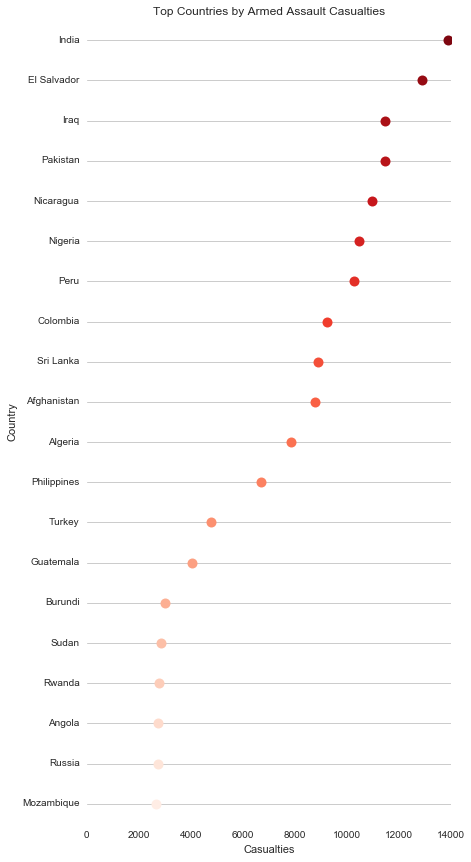

In [148]:
#it's having a really hard time keeping up when it has to recalculate, might need the "execute" button
interact(create_dot_plot, attacktype = attack_type(), year_range = year_interval(), metric = metric_selection(),__manual=True);